# Machine Learning with PyTorch and Scikit-Learn  

#### CHANGES ####
Moved imports to a dedicated cell.
Moved magic nubmers to a dedicated constants cell

Imports

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import numpy as np
import numpy as np


Constants

In [2]:
RANDOM_SEED: int = 123
NUM_EPOCHS: int = 50
LEARNING_RATE: float = 0.1
TRAIN_TEST_SPLIT = 0.3
TRAIN_VALIDATION_SPLIT = 0.2

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [4]:
X = ((X / 255.) - .5) * 2

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TRAIN_TEST_SPLIT, random_state=RANDOM_SEED, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=TRAIN_VALIDATION_SPLIT, random_state=RANDOM_SEED, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

## Implementing a multi-layer perceptron

The model was changed to be modular to support an arbitrary number of layers.

In [6]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for index, val in enumerate(y):
        ary[index, val] = 1

    return ary

class NeuralNetMLP:
    def __init__(self, 
                 num_features: int, 
                 hidden_layers_sizes: list[int],
                 num_classes: int,
                 random_seed=RANDOM_SEED
                 ):
        
        
        if len(hidden_layers_sizes) < 1:
            raise ValueError("hidden_layers_sizes must contain at least one layer.")
        rng = np.random.RandomState(random_seed)
        self.num_classes = num_classes
        self.layer_weights = [rng.normal(loc=0.0, scale=0.1, size=(hidden_layers_sizes[0], num_features))]
        self.biases = list()
        # hidden
        
        
        for index in range(1, len(hidden_layers_sizes)):
            self.layer_weights.append(
                rng.normal(
                    loc=0.0, 
                    scale=0.1, 
                    size=(hidden_layers_sizes[index], hidden_layers_sizes[index-1])
                )
            )
        for index in range(len(hidden_layers_sizes)):
            self.biases.append(np.zeros(hidden_layers_sizes[index]))

        # output
        self.layer_weights.append(rng.normal(loc=0.0, scale=0.1, size=(num_classes, hidden_layers_sizes[-1])))
        self.biases.append(np.zeros(num_classes))
        
    def forward(self, input: np.ndarray):
        layer_activations = []
        layer_pre_activations = []  # store z for ReLU derivative
        current_input = input

        num_of_layers = len(self.layer_weights)
        for layer_index in range(num_of_layers):
            z = np.dot(current_input, self.layer_weights[layer_index].T) + self.biases[layer_index]
            layer_pre_activations.append(z)
            a = sigmoid(z)
            layer_activations.append(a)
            current_input = a

        return layer_activations, layer_activations[-1]

    def backward(self, input, layer_activations, network_output, targets):
        N = input.shape[0]
        targets_onehot = int_to_onehot(targets, self.num_classes)

        num_layers = len(self.layer_weights)
        loss_weights_list = [None] * num_layers
        loss_biases_list  = [None] * num_layers

        # output delta (sigmoid + MSE)
        a_out = network_output
        d_loss__d_a = 2.0 * (a_out - targets_onehot) / N
        delta = d_loss__d_a * (a_out * (1.0 - a_out))

        # backprop
        for layer_idx in range(num_layers - 1, -1, -1):
            a_prev = input if layer_idx == 0 else layer_activations[layer_idx - 1]

            loss_weights_list[layer_idx] = np.dot(delta.T, a_prev)
            loss_biases_list[layer_idx]  = np.sum(delta, axis=0)

            if layer_idx > 0:
                curr_W = self.layer_weights[layer_idx]
                d_loss__d_a_prev = np.dot(delta, curr_W)

                a_prev_act = layer_activations[layer_idx - 1]
                delta = d_loss__d_a_prev * (a_prev_act * (1.0 - a_prev_act))

        return loss_weights_list, loss_biases_list




In [7]:
multi_layer_model = NeuralNetMLP(num_features=28*28,
                     hidden_layers_sizes=[50, 50],
                     num_classes=10)
single_layer_model = NeuralNetMLP(num_features=28*28,
                     hidden_layers_sizes=[50],
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [8]:
num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [9]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

def evaluate_model(model, features, true_labels):
    _, probas = model.forward(features)
    mse = mse_loss(true_labels, probas)
    predicted_labels = np.argmax(probas, axis=1)
    acc = accuracy(true_labels, predicted_labels)
    return acc, mse

In [10]:
acc, mse = evaluate_model(single_layer_model, X_valid, y_valid)
print('Evaluating single layer model...')
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')
acc, mse = evaluate_model(multi_layer_model, X_valid, y_valid)
print('Evaluating double layer model...')
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Evaluating single layer model...
Initial validation MSE: 0.3
Initial validation accuracy: 9.3%
Evaluating double layer model...
Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [11]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [12]:
mse, acc = compute_mse_and_acc(single_layer_model, X_valid, y_valid)
print('Evaluating single layer model...')
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')
mse, acc = compute_mse_and_acc(multi_layer_model, X_valid, y_valid)
print('Evaluating double layer model...')
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Evaluating single layer model...
Initial valid MSE: 0.3
Initial valid accuracy: 9.3%
Evaluating double layer model...
Initial valid MSE: 0.2
Initial valid accuracy: 9.0%


In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
def compute_auc(model, X, y):
    _, probas = model.forward(X)
    y_onehot = int_to_onehot(y, num_labels=model.num_classes)
    macro_auc = roc_auc_score(y_onehot, probas, multi_class="ovr", average="macro")
    return macro_auc

In [15]:
single_layer_auc = compute_auc(single_layer_model, X_valid, y_valid)
double_layer_auc = compute_auc(multi_layer_model, X_valid, y_valid)
print('Evaluating single layer model...')
print(f'Initial AUC single_layer: {single_layer_auc:.5f}')
print('Evaluating double layer model...')
print(f'Initial AUC double_layer: {double_layer_auc:.5f}')

Evaluating single layer model...
Initial AUC single_layer: 0.52122
Evaluating double layer model...
Initial AUC double_layer: 0.52947


In [16]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=LEARNING_RATE,):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_valid_loss = []

    for e in range(num_epochs):

        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Forward ####
            activations_list, a_out = model.forward(X_train_mini)
            #### Backward ####
            weight_loss_list, bias_loss_list = model.backward(
                X_train_mini,
                activations_list,
                a_out,
                y_train_mini
            )

            #### Update ####
            for layer_idx in range(len(model.layer_weights)):
                model.layer_weights[layer_idx] -= learning_rate * weight_loss_list[layer_idx]
                model.biases[layer_idx]        -= learning_rate * bias_loss_list[layer_idx]


        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

        train_acc *= 100.0
        valid_acc *= 100.0

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        epoch_valid_loss.append(valid_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.5f} '
              f'| Train Acc: {train_acc:.5f}% '
              f'| Valid Acc: {valid_acc:.5f}% '
              f'| Valid Loss: {valid_mse:.5f}')
    return epoch_loss, epoch_valid_loss, epoch_train_acc, epoch_valid_acc


In [17]:
np.random.seed(RANDOM_SEED) # for the training set shuffling

In [18]:
print('Training single layer model...')
single_layer_epoch_loss, single_layer_epoch_valid_loss, single_layer_epoch_train_acc, single_layer_epoch_valid_acc = train(
    single_layer_model, X_train, y_train, X_valid, y_valid,
    num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)

Training single layer model...
Epoch: 001/050 | Train MSE: 0.06193 | Train Acc: 69.22194% | Valid Acc: 69.75510% | Valid Loss: 0.06164
Epoch: 002/050 | Train MSE: 0.03900 | Train Acc: 81.82143% | Valid Acc: 81.90816% | Valid Loss: 0.03870
Epoch: 003/050 | Train MSE: 0.02965 | Train Acc: 86.20153% | Valid Acc: 86.08163% | Valid Loss: 0.02946
Epoch: 004/050 | Train MSE: 0.02484 | Train Acc: 87.95663% | Valid Acc: 87.81633% | Valid Loss: 0.02473
Epoch: 005/050 | Train MSE: 0.02204 | Train Acc: 88.96684% | Valid Acc: 88.73469% | Valid Loss: 0.02201
Epoch: 006/050 | Train MSE: 0.02007 | Train Acc: 89.63776% | Valid Acc: 89.30612% | Valid Loss: 0.02009
Epoch: 007/050 | Train MSE: 0.01880 | Train Acc: 90.12755% | Valid Acc: 89.82653% | Valid Loss: 0.01887
Epoch: 008/050 | Train MSE: 0.01766 | Train Acc: 90.53827% | Valid Acc: 90.32653% | Valid Loss: 0.01777
Epoch: 009/050 | Train MSE: 0.01685 | Train Acc: 90.85714% | Valid Acc: 90.76531% | Valid Loss: 0.01699
Epoch: 010/050 | Train MSE: 0.016

In [19]:
print('Training double layer model...')
double_layer_epoch_loss, double_layer_epoch_valid_loss,double_layer_epoch_train_acc, double_layer_epoch_valid_acc = train(
    multi_layer_model, X_train, y_train, X_valid, y_valid,
    num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)


Training double layer model...
Epoch: 001/050 | Train MSE: 0.08934 | Train Acc: 17.46173% | Valid Acc: 17.34694% | Valid Loss: 0.08934
Epoch: 002/050 | Train MSE: 0.08818 | Train Acc: 25.11990% | Valid Acc: 24.97959% | Valid Loss: 0.08817
Epoch: 003/050 | Train MSE: 0.08453 | Train Acc: 28.68367% | Valid Acc: 28.45918% | Valid Loss: 0.08452
Epoch: 004/050 | Train MSE: 0.07481 | Train Acc: 40.12755% | Valid Acc: 39.98980% | Valid Loss: 0.07475
Epoch: 005/050 | Train MSE: 0.06498 | Train Acc: 56.92602% | Valid Acc: 56.92857% | Valid Loss: 0.06487
Epoch: 006/050 | Train MSE: 0.05427 | Train Acc: 65.45918% | Valid Acc: 65.61224% | Valid Loss: 0.05410
Epoch: 007/050 | Train MSE: 0.04562 | Train Acc: 73.26786% | Valid Acc: 73.57143% | Valid Loss: 0.04542
Epoch: 008/050 | Train MSE: 0.03900 | Train Acc: 79.82653% | Valid Acc: 80.29592% | Valid Loss: 0.03881
Epoch: 009/050 | Train MSE: 0.03323 | Train Acc: 84.92857% | Valid Acc: 85.04082% | Valid Loss: 0.03302
Epoch: 010/050 | Train MSE: 0.028

## Evaluating the neural network performance

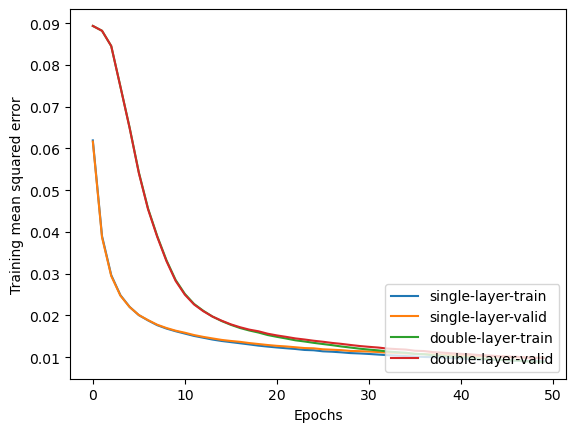

In [20]:
plt.figure()
plt.plot(range(len(single_layer_epoch_loss)), single_layer_epoch_loss, label="single-layer-train")
plt.plot(range(len(single_layer_epoch_valid_loss)), single_layer_epoch_valid_loss, label="single-layer-valid")
plt.plot(range(len(double_layer_epoch_loss)), double_layer_epoch_loss, label="double-layer-train")
plt.plot(range(len(double_layer_epoch_valid_loss)), double_layer_epoch_valid_loss, label="double-layer-valid")
plt.ylabel("Training mean squared error")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.show()

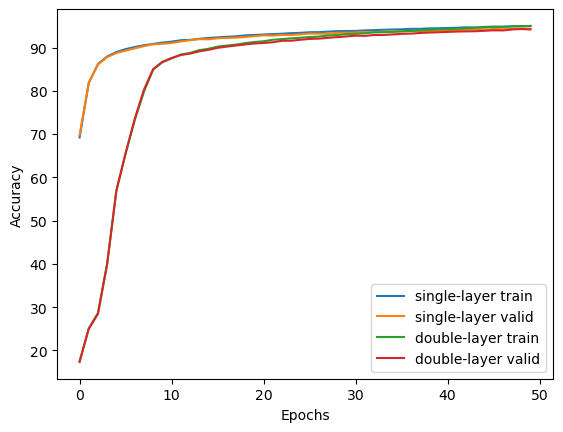

In [ ]:
plt.figure()

# single-layer
plt.plot(single_layer_epoch_train_acc, label="single-layer train")
plt.plot(single_layer_epoch_valid_acc, label="single-layer valid")

# double-layer
plt.plot(double_layer_epoch_train_acc, label="double-layer train")
plt.plot(double_layer_epoch_valid_acc, label="double-layer valid")

plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.show()

In [22]:
single_layer_test_mse, single_layer_test_acc = compute_mse_and_acc(single_layer_model, X_test, y_test)
double_layer_test_mse, double_layer_test_acc = compute_mse_and_acc(multi_layer_model, X_test, y_test)
print(f'Test accuracy, single layer: {single_layer_test_acc*100:.2f}%')
print(f'Test accuracy, double layer: {double_layer_test_acc*100:.2f}%')
print(f'Test error, single layer: {single_layer_test_mse:.5f}')
print(f'Test error, double layer: {double_layer_test_mse:.5f}')

Test accuracy, single layer: 94.13%
Test accuracy, double layer: 94.05%
Test error, single layer: 0.01024
Test error, double layer: 0.01008


In [23]:
single_layer_auc = compute_auc(single_layer_model, X_valid, y_valid)
double_layer_auc = compute_auc(multi_layer_model, X_valid, y_valid)
print('Evaluating single layer model...')
print(f'AUC single_layer after training: {single_layer_auc:.5f}')
print('Evaluating double layer model...')
print(f'AUC double_layer after training: {double_layer_auc:.5f}')

Evaluating single layer model...
AUC single_layer after training: 0.99225
Evaluating double layer model...
AUC double_layer after training: 0.99256


Plot failure cases:

Single layer model

In [24]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = single_layer_model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

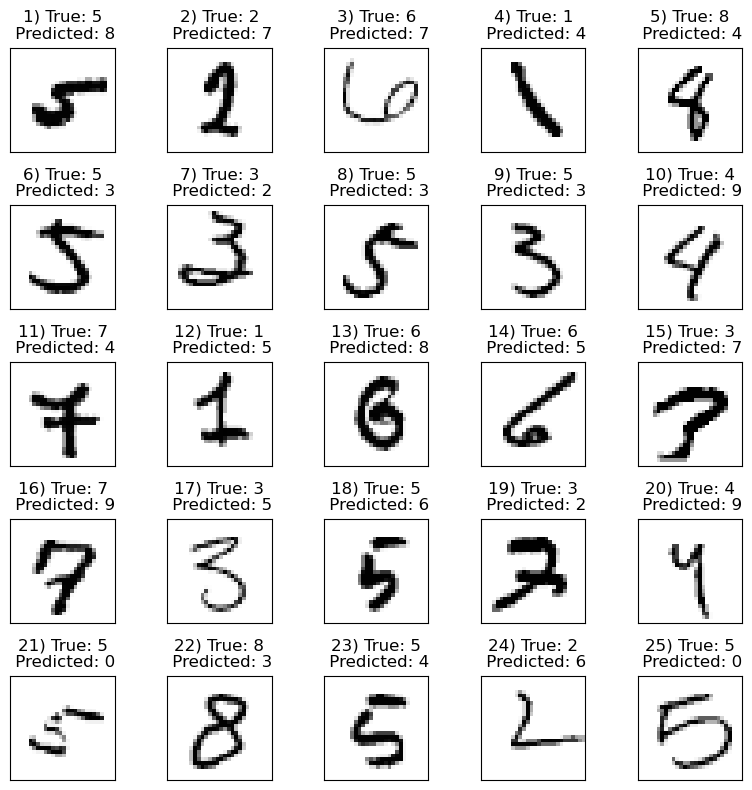

In [25]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

Double layer model

In [26]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = multi_layer_model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

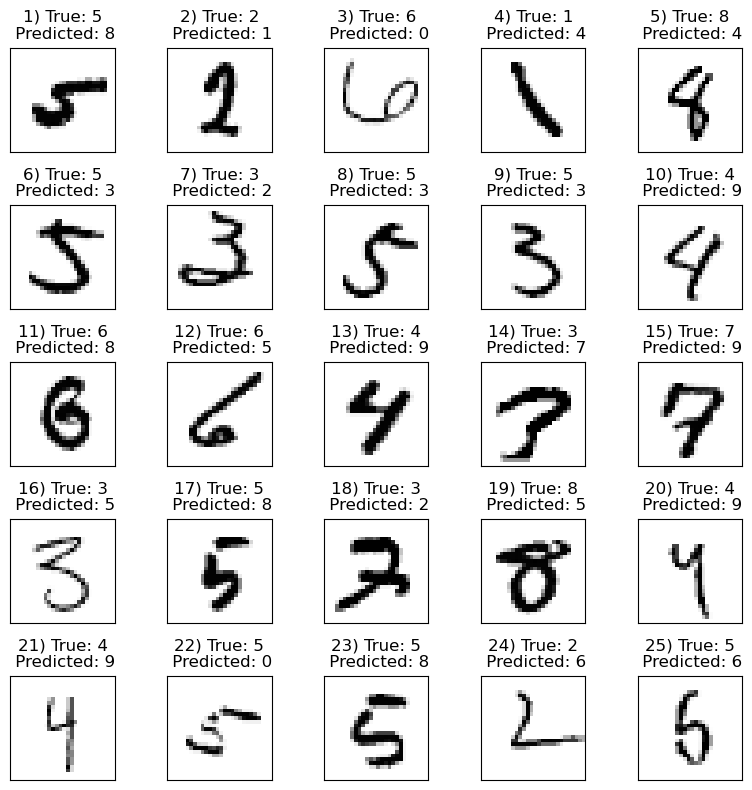

In [27]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

<span style="font-size:20px;">Implementing an ANN according to the lecture notes.</span>

imports

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt


Constants relating to the ANN

In [29]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_VALIDATION = 100
BATCH_SIZE_TEST = 100
ANN_LEARNING_RATE = 0.1
HEIGHT = 28
WIDTH = 28
INPUT_SIZE = HEIGHT * WIDTH
NUM_CLASSES = 10
NUM_EPOCHS = 50
RANDOM_SEED_FOR_ANN = 42
HIDDEN_LAYER_SIZES = [500, 500]

In [30]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) # mean and std for MNIST
full_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
# Splitting to train and validation sets
test_set_size = int(TRAIN_TEST_SPLIT * len(full_train))
training_set_size = len(full_train) - test_set_size
validation_set_size = int(TRAIN_VALIDATION_SPLIT * training_set_size)
final_training_set_size = len(full_train) - test_set_size - validation_set_size
train_dataset, test_dataset = random_split(
    full_train,
    [training_set_size, test_set_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED_FOR_ANN)
)
train_dataset, val_dataset = random_split(
    train_dataset,
    [final_training_set_size, validation_set_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED_FOR_ANN)
)
len(train_dataset), len(val_dataset), len(test_dataset)

(33600, 8400, 18000)

In [31]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VALIDATION, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)
len(train_loader), len(validation_loader), len(test_loader)

(336, 84, 180)

Creating the neural network

In [32]:
class DenseNet(nn.Module):
    def __init__(self, input_size: int, hidden_layer_sizes: list[int], num_classes: int):
        super(DenseNet, self).__init__()
        layers = []
        in_size = input_size
        for h_size in hidden_layer_sizes:
            layers.append(nn.Linear(in_size, h_size))
            nn.init.xavier_uniform_(layers[-1].weight)
            nn.init.zeros_(layers[-1].bias)
            layers.append(nn.Sigmoid())
            in_size = h_size
        layers.append(nn.Linear(in_size, num_classes))
        layers.append(nn.Softmax(dim=1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [33]:
ann_dense_model = DenseNet(input_size=INPUT_SIZE,
                           hidden_layer_sizes=HIDDEN_LAYER_SIZES,
                           num_classes=NUM_CLASSES)
criterion = nn.MSELoss()
optimizer = optim.SGD(ann_dense_model.parameters(), lr=ANN_LEARNING_RATE)

In [34]:
def train_ann(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    num_epochs,
    num_classes
):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        # -------- TRAIN --------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data, target in train_loader:
            data = data.view(data.size(0), -1).float()
            target_onehot = F.one_hot(target, num_classes=num_classes).float()

            optimizer.zero_grad()
            output = model(data)  # model ends with softmax
            loss = criterion(output, target_onehot)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100.0 * correct / total

        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # -------- VALIDATION --------
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data = data.view(data.size(0), -1).float()
                target_onehot = F.one_hot(target, num_classes=num_classes).float()
                output = model(data)
                running_loss += criterion(output, target_onehot).item()
                pred = output.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += target.size(0)

        epoch_val_loss = running_loss / len(val_loader)
        epoch_val_acc = 100.0 * correct / total

        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(
            f"Epoch {epoch+1:02d} | "
            f"train loss {epoch_train_loss:.4f} | "
            f"train acc {epoch_train_acc:.2f}% | "
            f"val loss {epoch_val_loss:.4f} | "
            f"val acc {epoch_val_acc:.2f}%"
        )

    return train_losses, train_accs, val_losses, val_accs


In [35]:
train_losses, train_accs, val_losses, val_accs = train_ann(ann_dense_model, train_loader, validation_loader, optimizer, criterion, NUM_EPOCHS, NUM_CLASSES)

Epoch 01 | train loss 0.0896 | train acc 16.68% | val loss 0.0893 | val acc 23.61%
Epoch 02 | train loss 0.0889 | train acc 21.80% | val loss 0.0887 | val acc 23.21%
Epoch 03 | train loss 0.0883 | train acc 24.20% | val loss 0.0880 | val acc 27.05%
Epoch 04 | train loss 0.0875 | train acc 26.26% | val loss 0.0872 | val acc 27.62%
Epoch 05 | train loss 0.0866 | train acc 27.69% | val loss 0.0862 | val acc 27.31%
Epoch 06 | train loss 0.0853 | train acc 28.27% | val loss 0.0847 | val acc 29.70%
Epoch 07 | train loss 0.0836 | train acc 29.71% | val loss 0.0829 | val acc 27.10%
Epoch 08 | train loss 0.0812 | train acc 31.63% | val loss 0.0802 | val acc 32.82%
Epoch 09 | train loss 0.0783 | train acc 36.39% | val loss 0.0772 | val acc 37.18%
Epoch 10 | train loss 0.0750 | train acc 42.15% | val loss 0.0738 | val acc 45.82%
Epoch 11 | train loss 0.0716 | train acc 48.28% | val loss 0.0705 | val acc 49.50%
Epoch 12 | train loss 0.0682 | train acc 52.71% | val loss 0.0670 | val acc 54.27%
Epoc

In [36]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_network(model, test_loader, criterion, num_classes=NUM_CLASSES):
    model.eval()
    test_loss = 0.0
    correct = 0

    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1).float()
            output = model(data)  # (B, C) softmax probs in your case

            target_onehot = F.one_hot(target, num_classes=num_classes).float()
            test_loss += criterion(output, target_onehot).item()

            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()

            targets_list.append(target.detach().cpu().numpy())
            outputs_list.append(output.detach().cpu().numpy())

    y_true = np.concatenate(targets_list, axis=0)                  # (N,)
    y_score = np.concatenate(outputs_list, axis=0).astype(float)   # (N, C)

    # robust one-hot
    y_onehot = label_binarize(y_true, classes=np.arange(num_classes))  # (N, C)
    per_class = [roc_auc_score(y_onehot[:,c], y_score[:,c]) for c in range(num_classes)]
    print("per-class auc min/mean/max:", np.min(per_class), np.mean(per_class), np.max(per_class))
    macro_auc = roc_auc_score(y_onehot, y_score, multi_class="ovr", average="macro")

    test_loss /= len(test_loader)
    test_acc = 100.0 * correct / len(test_loader.dataset)
    print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%, Test AUC: {macro_auc:.5f}")

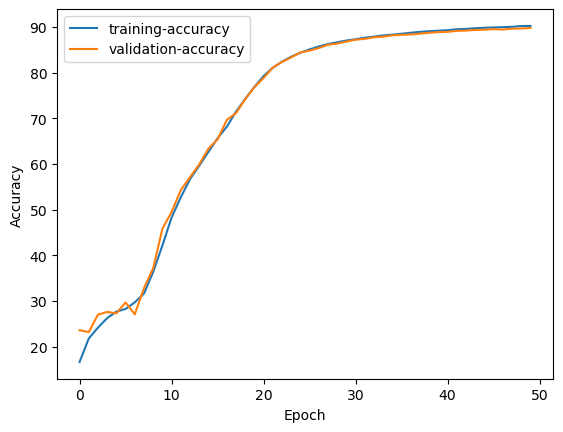

In [42]:
plt.figure()
plt.plot(range(len(train_accs)), train_accs, label="training-accuracy")
plt.plot(range(len(val_accs)), val_accs, label="validation-accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

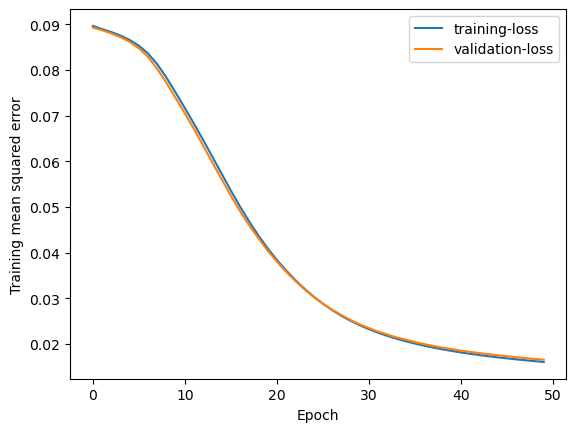

In [43]:
plt.figure()
plt.plot(range(len(train_losses)), train_losses, label="training-loss")
plt.plot(range(len(val_losses)), val_losses, label="validation-loss")
plt.ylabel("Training mean squared error")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Section 4: evaluating all models

In [44]:
print("Evaluating ANN dense model...")
evaluate_network(ann_dense_model, test_loader, criterion=criterion, num_classes=NUM_CLASSES)
print('')
single_layer_mse, single_layer_acc = compute_mse_and_acc(single_layer_model, X_valid, y_valid)
single_layer_auc = compute_auc(single_layer_model, X_valid, y_valid)
print('Evaluating single layer model...')
print(f'Test MSE: {single_layer_mse:.5f}')
print(f'Test accuracy: {single_layer_acc*100:.5f}%')
print(f'Test AUC: {single_layer_auc:.5f}')
print('')
double_layer_mse, double_layer_acc = compute_mse_and_acc(multi_layer_model, X_valid, y_valid)
double_layer_auc = compute_auc(multi_layer_model, X_valid, y_valid)
print('Evaluating double layer model...')
print(f'Test MSE: {double_layer_mse:.5f}')
print(f'Test accuracy: {double_layer_acc*100:.5f}%')
print(f'Test AUC: {double_layer_auc:.5f}')

Evaluating ANN dense model...
per-class auc min/mean/max: 0.9798244514761323 0.9895099300727997 0.9975138910597999
Test loss: 0.0167, Test accuracy: 89.34%, Test AUC: 0.98951

Evaluating single layer model...
Test MSE: 0.00987
Test accuracy: 94.35714%
Test AUC: 0.99225

Evaluating double layer model...
Test MSE: 0.00980
Test accuracy: 94.19388%
Test AUC: 0.99256


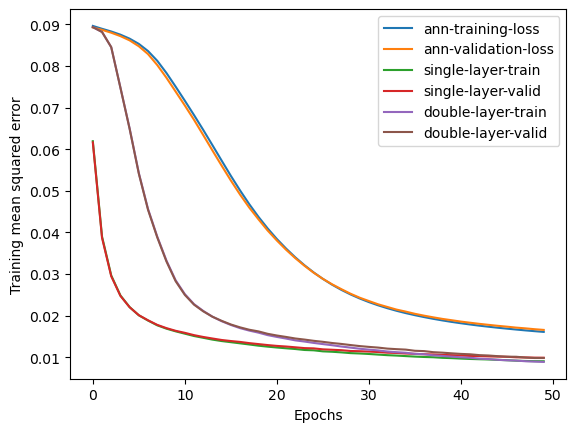

In [47]:
plt.figure()
plt.plot(range(len(train_losses)), train_losses, label="ann-training-loss")
plt.plot(range(len(val_losses)), val_losses, label="ann-validation-loss")
plt.plot(range(len(single_layer_epoch_loss)), single_layer_epoch_loss, label="single-layer-train")
plt.plot(range(len(single_layer_epoch_valid_loss)), single_layer_epoch_valid_loss, label="single-layer-valid")
plt.plot(range(len(double_layer_epoch_loss)), double_layer_epoch_loss, label="double-layer-train")
plt.plot(range(len(double_layer_epoch_valid_loss)), double_layer_epoch_valid_loss, label="double-layer-valid")
plt.ylabel("Training mean squared error")
plt.xlabel("Epoch")
plt.ylabel("Training mean squared error")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.show()

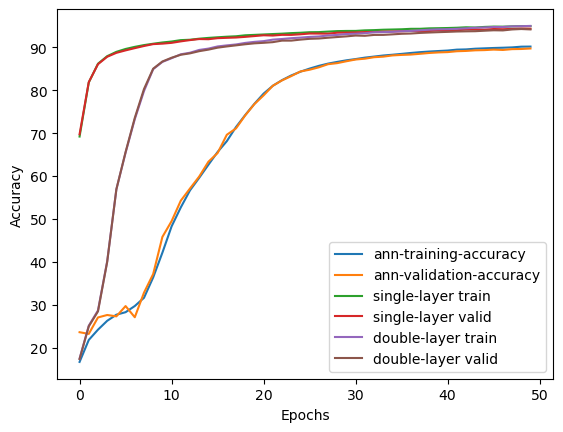

In [46]:
plt.figure()
plt.plot(range(len(train_accs)), train_accs, label="ann-training-accuracy")
plt.plot(range(len(val_accs)), val_accs, label="ann-validation-accuracy")
# single-layer
plt.plot(single_layer_epoch_train_acc, label="single-layer train")
plt.plot(single_layer_epoch_valid_acc, label="single-layer valid")

# double-layer
plt.plot(double_layer_epoch_train_acc, label="double-layer train")
plt.plot(double_layer_epoch_valid_acc, label="double-layer valid")

plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.show()